In [0]:
import random
import numpy as np
NUCLEOTIDES = "ACGT"
random.seed(123)

# Function to simulate multiple sequence alignments with errors and either no SNP or heterozygous SNP

In [0]:
def simulate_alignments(reference_length=200, num_alignments = 20000, 
                        coverage = 100, p_sequencing_error=0.0,
                        p_alignment_error=0.00):
    alignments = []
    mutation_types = []
    
    for i in range(num_alignments):
        snp_index = reference_length // 2
        if (i % 400 == 0):
            print("Computing alignment ", i)
        reference = [random.choice(NUCLEOTIDES) for _ in range(reference_length)]
        reference_base_at_snp = reference[snp_index]
        snp_base = random.choice([i for i in NUCLEOTIDES if i != reference_base_at_snp])
        mutation_type=random.choice([0,1,2]) # 0 -> no SNP; 1 -> Homozygous SNP; 2 -> Heterozygous SNP
        mutation_types.append(mutation_type)
        
        alignment = [reference]#first read is always the reference
        for _ in range(coverage):
            new_read = [reference[i] if random.random() > p_sequencing_error else random.choice(NUCLEOTIDES) for i in range(reference_length)]
            if random.random() < p_alignment_error:
                snp_index += random.randint(-1,2)
            if mutation_type == 1: #homozygous SNP
                new_read[snp_index] = snp_base
            if mutation_type == 2 and random.random() > 0.5: # heterozygous SNP
                new_read[snp_index] = snp_base

            if random.random() < p_sequencing_error: #Add errors to SNP region also
                new_read[snp_index] =  random.choice(NUCLEOTIDES)
            alignment.append(new_read)
        alignments.append(alignment)
    return alignments, mutation_types

In [6]:
# Compute 2000 alignments
alignments, mutation_types = simulate_alignments(num_alignments=2000)
alignments = np.array(alignments)

Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600


# Visualise the alignments

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
plt.rcParams['figure.dpi'] = 200

## Example one: No mutation - no  errors

Mutation type:  No mutation


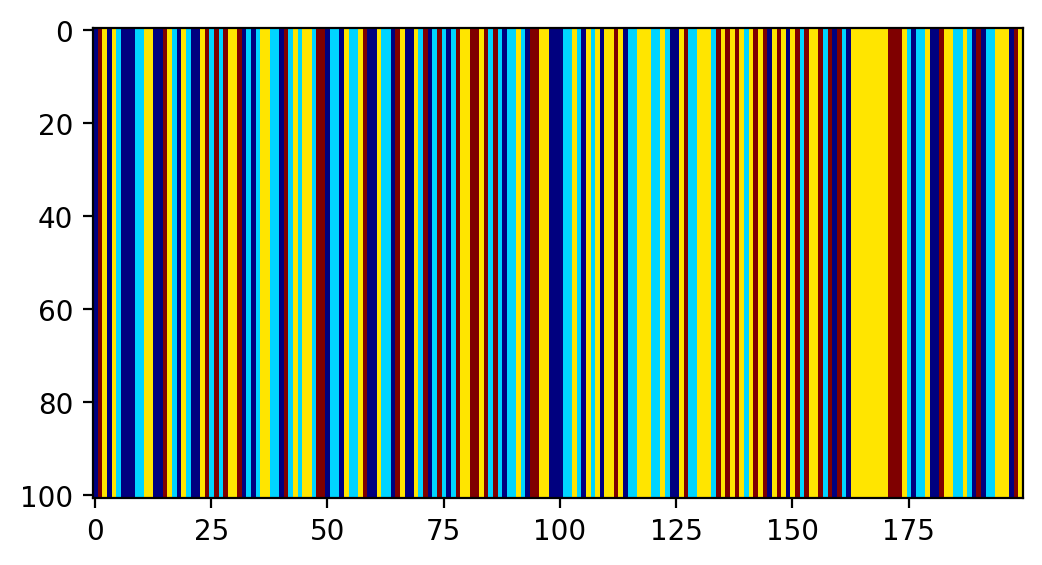

In [0]:
alignment_idx = 1
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
mutation_type_names = {0: "No mutation",
                 1: "Homozygous SNP",
                 2: "Heterozygous SNP"}
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

## Example 2: Heterozygous mutation - no errors

Mutation type:  Heterozygous SNP


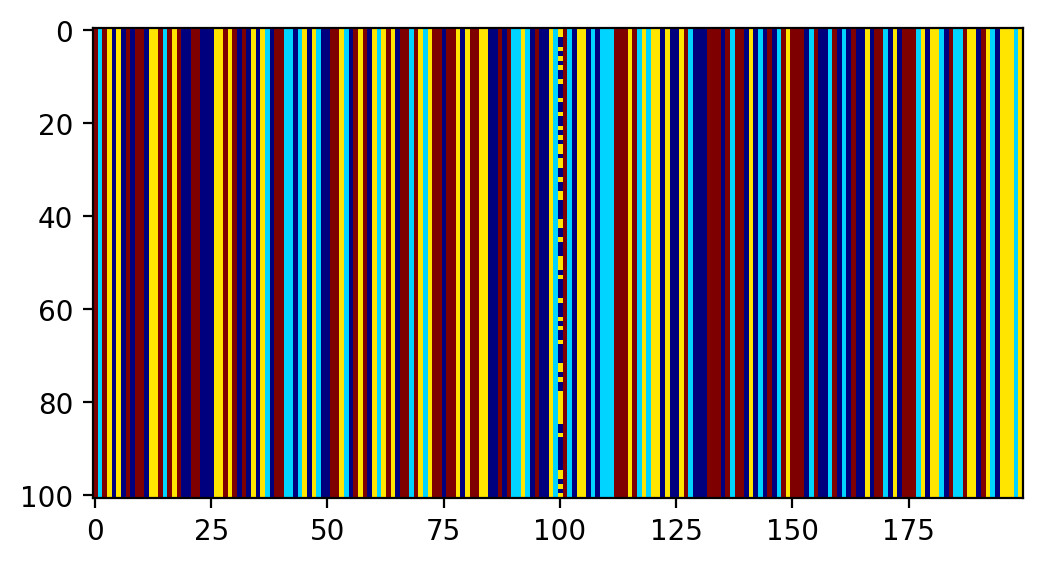

In [0]:
alignment_idx = 5
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
mutation_type_names = {0: "No mutation",
                 1: "Homozygous SNP",
                 2: "Heterozygous SNP"}
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

## Example 3: Homozygous mutation - no errors

Mutation type:  Homozygous SNP


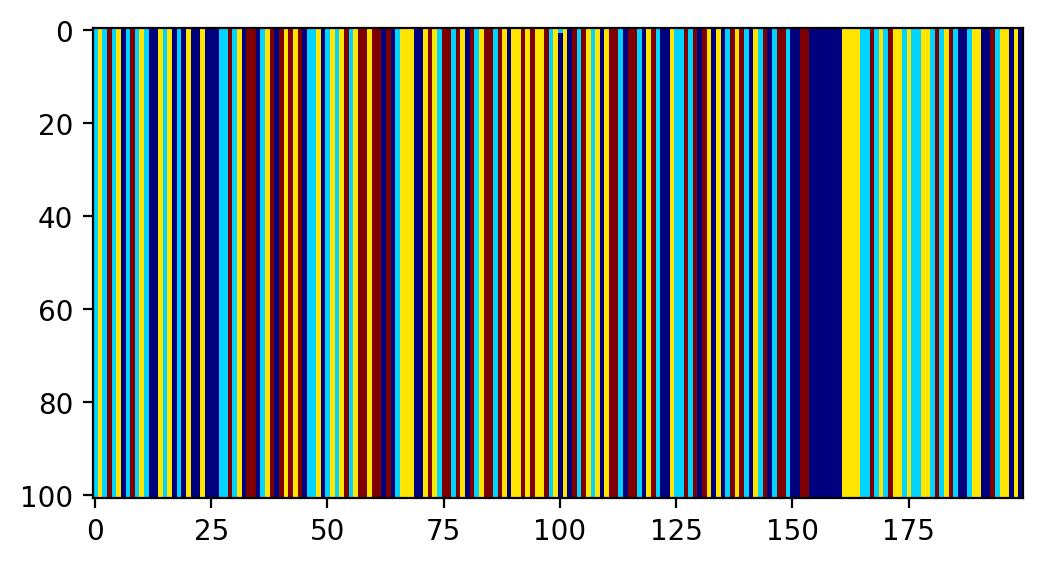

In [0]:
alignment_idx = 8
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
mutation_type_names = {0: "No mutation",
                 1: "Homozygous SNP",
                 2: "Heterozygous SNP"}
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

In [0]:
# Compute 2000 alignments
alignments, mutation_types = simulate_alignments(num_alignments=2000, p_alignment_error=0.05, p_sequencing_error=0.15)
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
plt.rcParams['figure.dpi'] = 200

Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600


# Example 4: No mutations, sequencing and alignment error

Mutation type:  No mutation


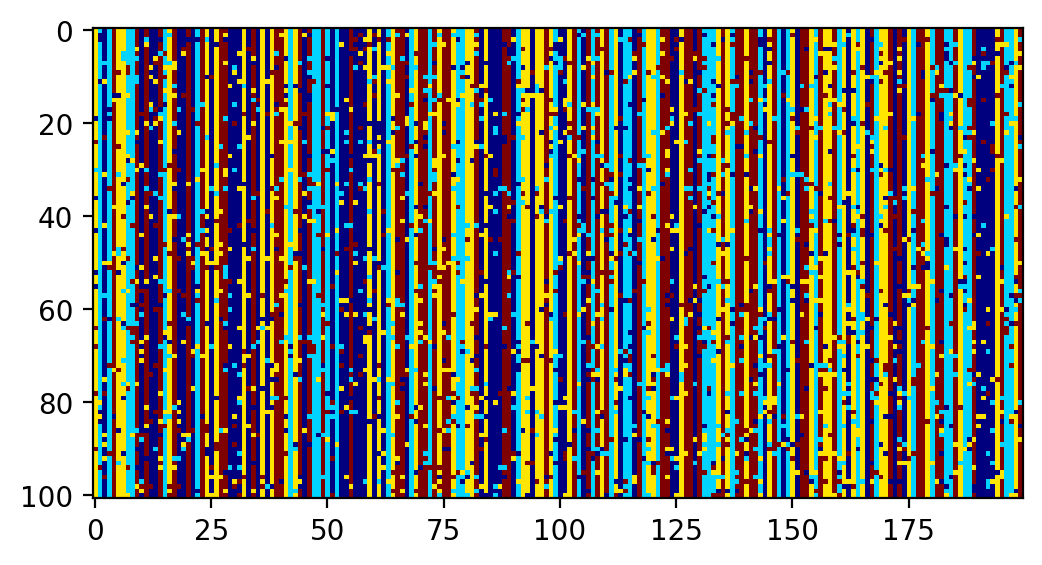

In [0]:
alignment_idx = 3
plt.imshow(alignments_ints[alignment_idx],cmap='jet')
mutation_type_names = {0: "No mutation",
                 1: "Homozygous SNP",
                 2: "Heterozygous SNP"}
print ("Mutation type: ", mutation_type_names[mutation_types[alignment_idx]])

In [0]:
# Exercises

# 1. Wite a neural network to classify SNPs into homozygous, heterozygous and no mutaiton in the absence of no errors
# 2. Measure its robustness to sequencing error
# 3. Measure its robustness to "alignment error"
# 4. How well does a model trained on one error rate perform on another? Can this model be made more robust for the "real world"?

In [0]:
# 1. Write a neural network to classify SNPs into homozygous, heterozygous and no mutaiton in the absence of no errors

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,  MaxPooling2D
from keras import backend as K

In [0]:
def create_x(alignments):
  # Get the Reference Read and Convert to 4 dim
  ref = keras.utils.to_categorical(alignments[:,0,:][:,np.newaxis,:], 4)

  # Get rid of Ref for all samples
  samples = keras.utils.to_categorical(alignments[:,1:,:],4)

  # #now add the other dimensions
  # # repeat the one dimesnion for the ref
  reads = samples.shape[1]
  ref = np.repeat(ref, reads, 1 )

  # # give two arrays and the dimension to concate on
  x = np.concatenate((samples,ref),3)
  return x

In [0]:
def get_train_test_data(x):
  img_rows, img_cols, channels = x.shape[1], x.shape[2] , x.shape[3]
  x_train, x_test, y_train, y_test = train_test_split(x, mutation_types, test_size = 0.20)

  if K.image_data_format() == 'channels_first':
      x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
      x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
      input_shape = (channels, img_rows, img_cols)
  else:
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
      input_shape = (img_rows, img_cols, channels)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  return x_train, x_test, y_train, y_test, input_shape

In [0]:
def make_model(input_shape,num_classes):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model


In [20]:
num_classes = 3
epochs = 20
batch_size = 128

# 1. Write a neural network to classify SNPs into homozygous, heterozygous and no mutaiton in the absence of no errors
alignments, mutation_types = simulate_alignments(num_alignments=2000)
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
x = create_x(alignments_ints)
x_train, x_test, y_train, y_test, input_shape = get_train_test_data(x)
model = make_model(input_shape,num_classes)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adadelta(),
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600
Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 4.2622 - acc: 0.3325 - val_loss: 1.0977 - val_acc: 0.3775
Epoch 2/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0892 - acc: 0.3956 - val_loss: 1.0940 - val_acc: 0.3700
Epoch 3/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0629 - acc: 0.4475 - val_loss: 1.0865 - val_acc: 0.4025
Epoch 4/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9995 - acc: 0.5300 - val_loss: 1.0748 - val_acc: 0.4075
Epoch 5/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9541 - acc: 0.5681 - val_loss: 0.9047 - val_acc: 0.6025
Epoch 6/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9437 - acc: 0.6794 - val_loss: 1.2746 - val_acc: 0.4725
Epoch 7/20
1600/1600 [==

In [21]:

# 2. Measure its robustness to sequencing error

# Sequencing Error is more Random than alignment error. So, I would suspect that the model would be more robust to this.

alignments, mutation_types = simulate_alignments(num_alignments=2000, p_sequencing_error=0.15)
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
x = create_x(alignments_ints)
x_train, x_test, y_train, y_test, input_shape = get_train_test_data(x)
model = make_model(input_shape,num_classes)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600
Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 3.1875 - acc: 0.3444 - val_loss: 1.0939 - val_acc: 0.3725
Epoch 2/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0920 - acc: 0.3825 - val_loss: 1.0932 - val_acc: 0.3725
Epoch 3/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0765 - acc: 0.4206 - val_loss: 1.0932 - val_acc: 0.3600
Epoch 4/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0353 - acc: 0.5025 - val_loss: 1.0960 - val_acc: 0.3575
Epoch 5/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9799 - acc: 0.5844 - val_loss: 1.1012 - val_acc: 0.3625
Epoch 6/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9155 - acc: 0.6494 - val_loss: 1.1130 - val_acc: 0.3500
Epoch 7/20
1600/1600 [==

In [22]:



# 3. Measure its robustness to "alignment error"

alignments, mutation_types = simulate_alignments(num_alignments=2000, p_alignment_error=0.15)
alignments = np.array(alignments)
transdict = {"A":0, "C": 1, "G":2, "T":3}
alignments_ints = np.vectorize(transdict.get)(alignments)
x = create_x(alignments_ints)
x_train, x_test, y_train, y_test, input_shape = get_train_test_data(x)
model = make_model(input_shape,num_classes)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Alignment Error is an error that will affect all reads in samples. It will be harder to detect this type of error.




Computing alignment  0
Computing alignment  400
Computing alignment  800
Computing alignment  1200
Computing alignment  1600
Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 3.0201 - acc: 0.3581 - val_loss: 1.0979 - val_acc: 0.3450
Epoch 2/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0785 - acc: 0.4163 - val_loss: 1.1022 - val_acc: 0.3225
Epoch 3/20
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0270 - acc: 0.4875 - val_loss: 1.1048 - val_acc: 0.3725
Epoch 4/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9602 - acc: 0.5587 - val_loss: 1.1405 - val_acc: 0.3450
Epoch 5/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.8952 - acc: 0.6062 - val_loss: 1.3667 - val_acc: 0.3400
Epoch 6/20
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7481 - acc: 0.6850 - val_loss: 1.2122 - val_acc: 0.3500
Epoch 7/20
1600/1600 [==

In [0]:
# 4. How well does a model trained on one error rate perform on another? Can this model be made more robust for the "real world"?